In [10]:
import pandas as pd
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
import tensorflow as tf

# Paths
csv_path = "fashion_data/fashion_data/styles.csv"  # Path to styles.csv
train_dir = "fashion_data/fashion_data/train"      # Train folder
val_dir = "fashion_data/fashion_data/validate"     # Validation folder
test_dir = "fashion_data/fashion_data/test"        # Test folder

# Mapping categories to labels
label_map = {"Casual": 0, "Formal": 1, "Smart Casual": 2}

def loadFromDirectory(csv_path, directory, limit):
    data = pd.read_csv(csv_path, on_bad_lines='skip') #loading styles, avoiding the corrupted lines
    images, labels = [], []
    count = 0

    for _, row in data.iterrows():
        if count >= limit:
            break
        img_id = str(row['id']) + ".jpg"
        category = row.get('usage')

        if category in label_map:
            label = label_map[category]
            img_path = os.path.join(directory, img_id)
            if os.path.exists(img_path):
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(60, 80))
                img_array = tf.keras.preprocessing.image.img_to_array(img) / 255
                images.append(img_array)
                labels.append(label)
                count += 1

    images = np.array(images)
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(label_map))
    return images, labels

#Loading the datasets with limits
train_images, train_labels = loadFromDirectory(csv_path, train_dir, 1400)
val_images, val_labels = loadFromDirectory(csv_path, val_dir, 300)
test_images, test_labels = loadFromDirectory(csv_path, test_dir, 300)

#Output dataset details
print("Training dataset size:", train_images.shape, train_labels.shape)
print("Validation dataset size:", val_images.shape, val_labels.shape)
print("Test dataset size:", test_images.shape, test_labels.shape)

Training dataset size: (924, 60, 80, 3) (924, 3)
Validation dataset size: (270, 60, 80, 3) (270, 3)
Test dataset size: (300, 60, 80, 3) (300, 3)

Training dataset class distribution:
Casual: 845 images
Formal: 29 images
Smart Casual: 50 images

Validation dataset class distribution:
Casual: 200 images
Formal: 20 images
Smart Casual: 50 images

Test dataset class distribution:
Casual: 239 images
Formal: 11 images
Smart Casual: 50 images


In [1]:
# Build the model
from keras import models, layers, optimizers
network = models.Sequential()
network.add(layers.Conv2D(16, (3,3), activation= 'relu', input_shape=(60, 80, 3)))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Conv2D(32, (3, 3), activation='relu'))
network.add(layers.MaxPooling2D(2, 2))
network.add(layers.Flatten())
network.add(layers.Dropout(0.5))
network.add(layers.Dense(30, activation='relu'))
network.add(layers.Dense(3, activation='softmax'))  # 3 categories
#Compiling the model
network.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
network.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 58, 78, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 29, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 37, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 18, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7488)              0         
                                                                 
 dropout (Dropout)           (None, 7488)              0

In [7]:
# Train the model
history = network.fit(train_images, train_labels, epochs=10, batch_size=5, validation_data=(val_images, val_labels))


Epoch 1/10
28/28 [==============================] - 3s 45ms/step - loss: 0.7194 - accuracy: 0.8500 - val_loss: 0.6897 - val_accuracy: 0.8333
Epoch 2/10
28/28 [==============================] - 1s 19ms/step - loss: 0.4960 - accuracy: 0.8786 - val_loss: 0.5895 - val_accuracy: 0.8333
Epoch 3/10
28/28 [==============================] - 0s 18ms/step - loss: 0.4647 - accuracy: 0.8786 - val_loss: 0.4695 - val_accuracy: 0.8333
Epoch 4/10
28/28 [==============================] - 0s 18ms/step - loss: 0.3623 - accuracy: 0.8786 - val_loss: 0.4822 - val_accuracy: 0.8333
Epoch 5/10
28/28 [==============================] - 0s 18ms/step - loss: 0.3283 - accuracy: 0.8786 - val_loss: 0.4650 - val_accuracy: 0.8333
Epoch 6/10
28/28 [==============================] - 1s 18ms/step - loss: 0.2920 - accuracy: 0.8857 - val_loss: 0.4390 - val_accuracy: 0.8333
Epoch 7/10
28/28 [==============================] - 1s 18ms/step - loss: 0.2210 - accuracy: 0.9071 - val_loss: 0.3656 - val_accuracy: 0.8333
Epoch 8/10
28

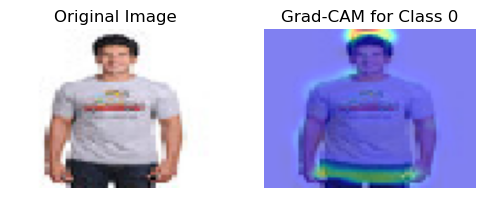

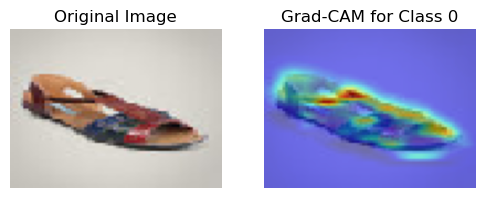

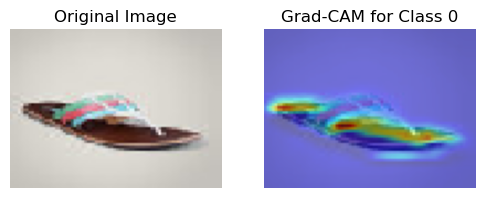

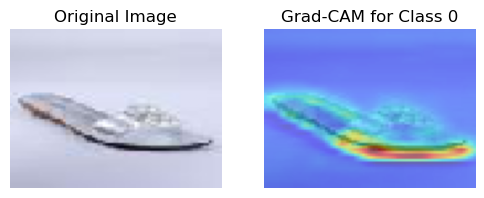

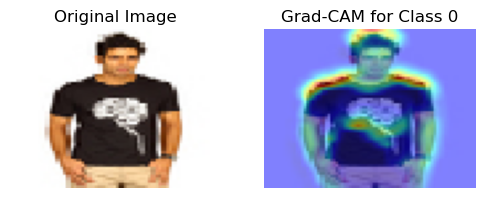

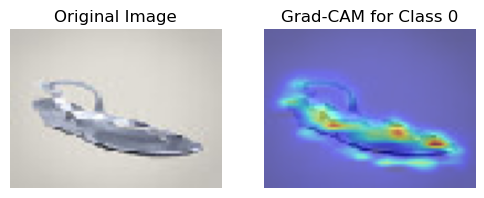

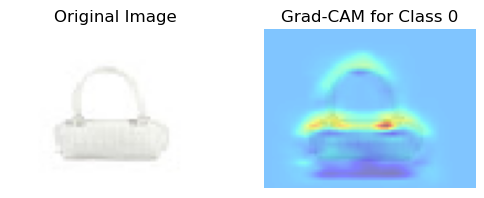

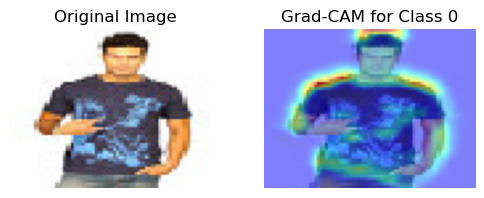

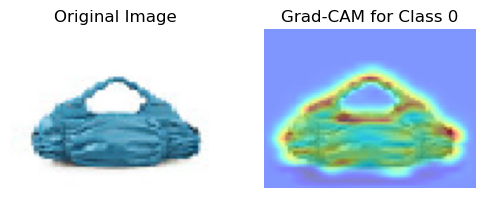

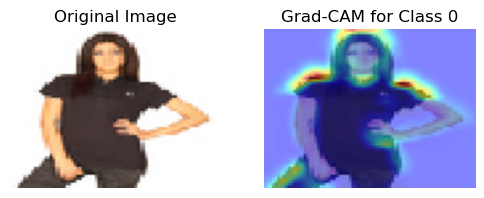

In [5]:
# Implementing the GRADCAM method to produce heatmaps
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

# GradCAM Visualization
for i in range(0, 10):
    label = np.argmax(train_labels[i])  # Convert one-hot encoded label to class index
    seed_input_image = train_images[i]
    seed_input_image = np.expand_dims(seed_input_image, axis=0)  # Add batch dimension

    # Initialize GradCAM
    gradcam = Gradcam(model=network, model_modifier=ReplaceToLinear(), clone=False)
    cam = gradcam(CategoricalScore(label), seed_input_image)

    # Post-process heatmap
    heatmap = np.uint8(cm.jet(cam[0])[..., :3] * 255)

    # Plot original image and heatmap overlay
    plt.figure(figsize=(6, 3))
    
    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(seed_input_image[0])  # Remove batch dimension for display
    plt.axis('off')
    plt.title('Original Image')

    # Grad-CAM Heatmap
    plt.subplot(1, 2, 2)
    plt.imshow(seed_input_image[0])  # Display original image
    plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
    plt.axis('off')
    plt.title(f'Grad-CAM for Class {label}')
    
    plt.show()


In [8]:
import pickle
# Save the history
with open("model_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

# Load the history
with open("model_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)

# Extract data
acc = loaded_history['accuracy']
val_acc = loaded_history['val_accuracy']
loss = loaded_history['loss']
val_loss = loaded_history['val_loss']
epochs = range(1, len(acc) + 1)

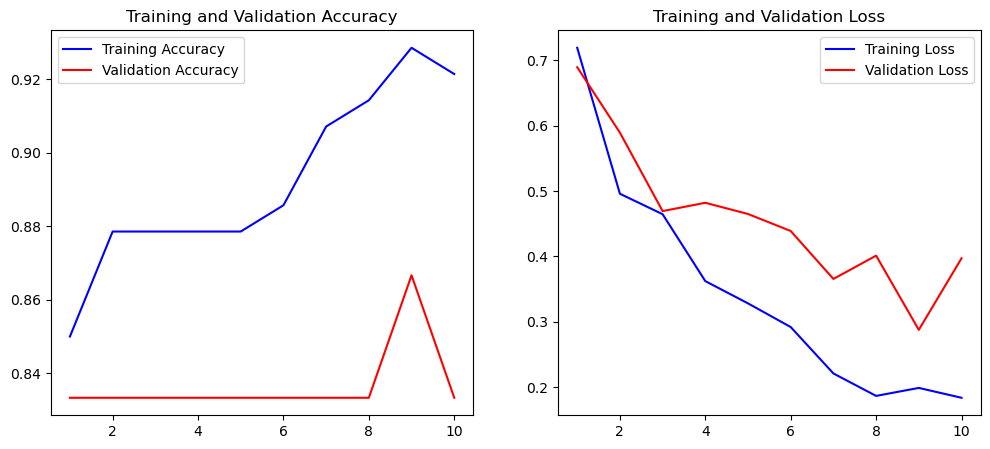

In [9]:
import matplotlib.pyplot as plt
# Plot accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()